# 유역별 수질 및 기상자료 분석


### 1. 라이브러리 로드 및 계절 정의 함수

In [1]:
# 라이브러리 로드
import pandas as pd
import numpy as np
from datetime import datetime

# 파일 내보내기위한 라이브러리
from pathlib import Path
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

In [2]:
# 시각화 라이브러리 로드
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter , ScalarFormatter
import seaborn as sns

# 시각화를 위한 한글 폰트 설정
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = 'NanumGothic'  
plt.rcParams['axes.unicode_minus'] = False  # 음수 깨짐 방지


In [3]:
# 분석 대상 유역 및 기상대
단위유역 = "섬강A"
기상대 = "횡성"

# 분석 기간 설정
시작연도 = 2015
종료연도 = 2024

In [4]:
# 계절 정의 함수 (월 기준)
def add_season(df, month_column='월'):
    """월 정보를 바탕으로 계절 컬럼 추가"""
    df = df.copy()
    conditions = [
        df[month_column].between(3, 5),
        df[month_column].between(6, 8),
        df[month_column].between(9, 11)
    ]
    seasons = ['봄', '여름', '가을']
    df['계절'] = np.select(conditions, seasons, default='겨울')
    df['계절'] = pd.Categorical(df['계절'], categories=['봄', '여름', '가을', '겨울'], ordered=True)
    return df


### 2. 기상자료 정리

In [5]:
# 기상자료(일단위) 정리
기상자료 = (
    pd.read_excel("E:/Coding/TMDL/수질분석/기상자료/기상자료_강수량_기온.xlsx")
    .query("지점명.str.contains(@기상대)", engine='python')  # regex 검색
    .drop(columns=["지점", "지점명"])
    .rename(columns={
        "일시": "일자",
        "평균기온(°C)": "평균기온",
        "일강수량(mm)": "일강수량"
    })
)

기상자료['일자'] = pd.to_datetime(기상자료['일자'])

# 연도, 월 컬럼 추가
기상자료['연도'] = 기상자료['일자'].dt.year
기상자료['월'] = 기상자료['일자'].dt.month

기상자료

,일자,평균기온,일강수량,연도,월
0,2015-01-01,-8.9,0.0,2015,1
1,2015-01-02,-8.6,0.0,2015,1
2,2015-01-03,-7.5,0.0,2015,1
3,2015-01-04,-1.0,0.0,2015,1
4,2015-01-05,-0.5,1.5,2015,1
...,...,...,...,...,...
3647,2024-12-27,-5.2,0.0,2024,12
3648,2024-12-28,-5.6,0.0,2024,12
3649,2024-12-29,-3.1,0.0,2024,12
3650,2024-12-30,2.1,0.0,2024,12


In [6]:
# 기상자료(시단위) 정리
기상자료_시단위 = (
    pd.read_excel("E:/Coding/TMDL/수질분석/기상자료/기상자료_강수량_기온_시단위.xlsx")
    .query("지점명.str.contains(@기상대)", engine='python')  # regex 검색
    .drop(columns=["지점", "지점명"])
    .rename(columns={
        "기온(°C)": "기온",
        "강수량(mm)": "강수량"
    })
)

기상자료_시단위['일시'] = pd.to_datetime(기상자료_시단위['일시'])
기상자료_시단위['일자'] = 기상자료_시단위['일시'].dt.date
기상자료_시단위['연도'] = 기상자료_시단위['일시'].dt.year
기상자료_시단위['월'] = 기상자료_시단위['일시'].dt.month

기상자료_시단위['고강도강우'] = 기상자료_시단위['강수량'] >= 20
기상자료_시단위['매우고강도강우'] = 기상자료_시단위['강수량'] >= 30

기상자료_시단위

,일시,기온,강수량,일자,연도,월,고강도강우,매우고강도강우
0,2015-01-01 00:00:00,-6.2,0.0,2015-01-01,2015,1,False,False
1,2015-01-01 01:00:00,-6.7,0.0,2015-01-01,2015,1,False,False
2,2015-01-01 02:00:00,-7.9,0.0,2015-01-01,2015,1,False,False
3,2015-01-01 03:00:00,-8.5,0.0,2015-01-01,2015,1,False,False
4,2015-01-01 04:00:00,-9.5,0.0,2015-01-01,2015,1,False,False
...,...,...,...,...,...,...,...,...
166244,2024-12-31 19:00:00,-2.8,0.0,2024-12-31,2024,12,False,False
166245,2024-12-31 20:00:00,-3.5,0.0,2024-12-31,2024,12,False,False
166246,2024-12-31 21:00:00,-4.8,0.0,2024-12-31,2024,12,False,False
166247,2024-12-31 22:00:00,-5.6,0.0,2024-12-31,2024,12,False,False


### 3. 강수량 분석

In [7]:
## 연월별 강수량 합계

# 연월별 강수량 합계
강수량_연월별_합계 = (
    기상자료.groupby(['연도', '월'])['일강수량']
    .sum()
    .reset_index(name='월강수량')
)

# 연도별 '소계' 행 생성
강수량_연월별_합계_소계 = (
    강수량_연월별_합계
    .groupby('연도')
    .apply(lambda df: pd.concat([
        df,
        pd.DataFrame([{
            '연도': df['연도'].iloc[0],
            '월': '소계',
            '월강수량': df['월강수량'].sum()
        }])
    ], ignore_index=True))
    .reset_index(drop=True)
)

강수량_연월별_합계_소계

C:\Users\TG\AppData\Local\Temp\ipykernel_30312\1268726770.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: pd.concat([


,연도,월,월강수량
0,2015,1,16.5
1,2015,2,13.0
2,2015,3,23.0
3,2015,4,91.5
4,2015,5,28.5
...,...,...,...
125,2024,9,198.0
126,2024,10,111.0
127,2024,11,55.0
128,2024,12,4.0


In [8]:
## 월별 강수량 평균
# '소계' 제외 후 월별 평균
강수량_월별_평균 = (
    강수량_연월별_합계
    .groupby('월')['월강수량']
    .mean()
    .round(1)
    .reset_index()
    .sort_values('월')
)

강수량_월별_평균

,월,월강수량
0,1,15.2
1,2,23.4
2,3,41.8
3,4,62.1
4,5,86.5
5,6,114.6
6,7,308.2
7,8,252.2
8,9,116.6
9,10,63.0


In [ ]:
## 일별 최대 시간강우량 및 강우강도 여부
# 일별 요약
# 고강도 강우(강한비) 확인 : 시간당 강수량 20mm이상(한강홍수통제소 기준)
기상지표_일별 = (
    기상자료_시단위
    .dropna(subset=['강수량'])  # 전부 NA인 날 제거
    .groupby('일자')
    .agg({
        '강수량': ['sum', 'max', lambda x: (x >= 20).any(), lambda x: (x >= 30).any()],
        '기온': 'mean'
    })
)

# 컬럼 이름 변경
기상지표_일별.columns = ['일강수량', '최대시간강우량', '고강도강우_발생여부', '매우고강도강우_발생여부', '평균기온']
# 인덱스 리셋 및 강우일 여부 추가
기상지표_일별 = 기상지표_일별.reset_index()
# 강우일 여부 추가
기상지표_일별['강우일'] = 기상지표_일별['일강수량'] > 0
# 평균기온 소수점 첫째자리로 반올림
기상지표_일별['평균기온'] = 기상지표_일별['평균기온'].round(1)

# 고강도강우 여부(기존) → int 변환 후 rolling 합계
기상지표_일별['고강도강우_발생여부_3일누적'] = (
    기상지표_일별['고강도강우_발생여부']
    .astype(int)                          # True/False → 1/0
    .rolling(window=3, min_periods=1)     # 최근 3일(당일 포함)
    .sum()                                # 합계 (3일 중 몇 번 발생했는지)
    .gt(0)                                # 0보다 크면 True
)

# 누적 강수량 계산
기상지표_일별['누적강수_3일'] = 기상지표_일별['일강수량'].rolling(window=3, min_periods=1).sum()
기상지표_일별['누적강수_4일'] = 기상지표_일별['일강수량'].rolling(window=4, min_periods=1).sum()
기상지표_일별['누적강수_5일'] = 기상지표_일별['일강수량'].rolling(window=5, min_periods=1).sum()


# 연도, 월 컬럼 추가
기상지표_일별['일자'] = pd.to_datetime(기상지표_일별['일자'])
기상지표_일별['연도'] = 기상지표_일별['일자'].dt.year
기상지표_일별['월'] = 기상지표_일별['일자'].dt.month

기상지표_일별

,일자,일강수량,최대시간강우량,고강도강우_발생여부,매우고강도강우_발생여부,평균기온,강우일,고강도강우_발생여부_3일누적,누적강수_3일,누적강수_4일,누적강수_5일,연도,월
0,2015-01-01,0.0,0.0,False,False,-8.3,False,False,0.0,0.0,0.0,2015,1
1,2015-01-02,0.0,0.0,False,False,-8.7,False,False,0.0,0.0,0.0,2015,1
2,2015-01-03,0.0,0.0,False,False,-8.2,False,False,0.0,0.0,0.0,2015,1
3,2015-01-04,0.0,0.0,False,False,-1.0,False,False,0.0,0.0,0.0,2015,1
4,2015-01-05,0.0,0.0,False,False,-1.0,False,False,0.0,0.0,0.0,2015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,2024-12-27,0.0,0.0,False,False,-5.3,False,False,0.0,0.0,0.0,2024,12
3648,2024-12-28,0.0,0.0,False,False,-5.3,False,False,0.0,0.0,0.0,2024,12
3649,2024-12-29,0.0,0.0,False,False,-3.7,False,False,0.0,0.0,0.0,2024,12
3650,2024-12-30,0.0,0.0,False,False,2.0,False,False,0.0,0.0,0.0,2024,12


In [10]:
## 연도별 기상 지표 요약
기상지표_연도별 = (
    기상지표_일별.groupby('연도')
    .agg(
        강수량_합계=pd.NamedAgg(column='일강수량', aggfunc='sum'),
        강수량_일평균=pd.NamedAgg(column='일강수량', aggfunc=lambda x: round(x.mean(), 1)),
        강우일수=pd.NamedAgg(column='강우일', aggfunc='sum'),
        고강도일수=pd.NamedAgg(column='고강도강우_발생여부', aggfunc='sum'),
        평균기온=pd.NamedAgg(column='평균기온', aggfunc=lambda x: round(x.mean(), 1))
    )
).reset_index()

# 고강도비율 추가
기상지표_연도별['고강도비율'] = (
    (기상지표_연도별['고강도일수'] / 기상지표_연도별['강우일수']) * 100
).round(1)

# 평균기온 열을 맨뒤로 이동(꺼내고 맨 뒤에 다시 추가)
평균기온 = 기상지표_연도별.pop('평균기온')
기상지표_연도별['평균기온'] = 평균기온

기상지표_연도별

,연도,강수량_합계,강수량_일평균,강우일수,고강도일수,고강도비율,평균기온
0,2015,652.5,1.8,90,1,1.1,12.0
1,2016,963.0,2.6,90,1,1.1,12.1
2,2017,1178.0,3.2,92,6,6.5,11.3
3,2018,1242.0,3.4,80,4,5.0,11.4
4,2019,838.0,2.3,81,2,2.5,11.7
5,2020,1340.0,3.7,90,5,5.6,11.4
6,2021,966.0,2.6,92,0,0.0,11.8
7,2022,1666.0,4.6,86,6,7.0,11.2
8,2023,1314.0,3.6,89,1,1.1,12.3
9,2024,1422.5,3.9,100,5,5.0,13.0


### 4. 수질데이터(총량측정망) 정리

In [11]:
# 목표수질 불러오기
목표수질 = pd.read_excel("E:/Coding/TMDL/수질분석/목표수질.xlsx")
목표수질_TP = 목표수질.loc[목표수질['총량지점명'] == 단위유역, 'TP_목표수질'].values[0]

목표수질_TP

np.float64(0.035)

In [12]:
# 수질측정망 정리(단위유역 말단 측정망 외에 소유역까지 포함)
수질측정망 = (
    pd.read_excel("E:/Coding/TMDL/수질분석/총량측정망_소유역포함_2007_2024.xlsx")
    .dropna(subset=['TP'])  # TP 결측 제거
    .query("총량지점명.str.contains(@단위유역) and 연도 >= @시작연도 and 연도 <= @종료연도")
)

# 계절 추가
수질측정망 = add_season(수질측정망)

# 목표수질 초과 여부
수질측정망['달성여부'] = np.where(수질측정망['TP'] > 목표수질_TP, "초과", "달성")

수질측정망

,총량지점명,일자,BOD,TP,유량,TOC,수온,pH,EC,DO,COD,SS,TN,연도,월,계절,달성여부
20093,섬강A,2015-01-28,11.1,0.019,1.360,8.0,2.6,8.3,300.0,12.5,7.5,1.6,3.125,2015,1,겨울,달성
20094,섬강A,2015-02-11,10.6,0.015,1.038,5.5,3.2,8.1,293.0,12.9,5.9,0.6,3.110,2015,2,겨울,달성
20095,섬강A,2015-03-04,5.2,0.016,1.607,2.3,5.6,8.2,263.0,12.1,4.7,1.8,2.764,2015,3,봄,달성
20096,섬강A,2015-03-11,7.0,0.023,1.135,2.7,4.6,7.9,276.0,11.8,5.4,2.7,2.707,2015,3,봄,달성
20097,섬강A,2015-03-18,8.3,0.027,1.293,2.9,8.5,7.7,273.0,9.5,5.7,2.4,2.627,2015,3,봄,달성
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20964,섬강A3,2024-11-15,0.6,0.011,5.624,1.7,14.4,8.2,148.0,11.8,2.1,0.4,2.623,2024,11,가을,달성
20965,섬강A3,2024-11-22,1.0,0.011,5.026,1.9,10.5,8.2,147.0,12.8,2.8,0.4,2.448,2024,11,가을,달성
20966,섬강A3,2024-11-28,0.7,0.015,9.507,1.6,6.1,7.9,273.0,13.4,2.9,0.4,2.362,2024,11,가을,달성
20967,섬강A3,2024-12-05,0.5,0.007,8.747,1.5,5.0,8.0,155.0,14.3,1.6,0.6,2.574,2024,12,겨울,달성


In [13]:
## 총량측정망 자료 정리
# 1. 분석 대상 유역만 필터링
총량측정망 = 수질측정망[수질측정망['총량지점명'] == 단위유역].copy()

# 2. T-P 부하량 계산
총량측정망['측정부하량_TP'] = 총량측정망['유량'] * 총량측정망['TP'] * 86.4
총량측정망['목표부하량_TP'] = 총량측정망['유량'] * 목표수질_TP * 86.4

# 3. 유량 기준 내림차순 정렬
총량측정망 = 총량측정망.sort_values(by='유량', ascending=False).reset_index(drop=True)

# 4. 유량 크기 순서(동일값은 동일한 순위 부여)
총량측정망['유량크기순서'] = 총량측정망['유량'].rank(method='min', ascending=False)

# 5. 유량 유효 개수 계산(유량 값이 있는 행의 개수)
유량_유효개수 = 총량측정망['유량'].notna().sum()

# 6. 백분율 계산(NA는 자동으로 NaN 유지됨)
총량측정망['유량백분율'] = 총량측정망['유량크기순서'] / 유량_유효개수 * 100

# 7. 유황구간 정의
bins = [0, 10, 40, 60, 90, 100]
labels = ['홍수기', '풍수기', '평수기', '저수기', '갈수기']
총량측정망['유황구간'] = pd.cut(
    총량측정망['유량백분율'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True  # 경계 포함 여부, 필요시 False로 조정
)

# 8. 기상자료 병합(일자, 연도, 월 기준)
총량측정망 = pd.merge(총량측정망, 기상지표_일별, on=['일자', '연도', '월'], how='left')


# 9. '유량크기순서'열을 첫번째 열로 이동
# '유량크기순서' 열을 첫번째로 배치하고, 
# 나머지 모든 열의 이름들을 리스트로 만들어 그 뒤에 배치
총량측정망 = 총량측정망[['유량크기순서'] + [col for col in 총량측정망.columns if col != '유량크기순서']]

총량측정망

,유량크기순서,총량지점명,일자,BOD,TP,유량,TOC,수온,pH,EC,...,일강수량,최대시간강우량,고강도강우_발생여부,매우고강도강우_발생여부,평균기온,강우일,고강도강우_발생여부_3일누적,누적강수_3일,누적강수_4일,누적강수_5일
0,1.0,섬강A,2023-07-13,1.2,0.116,188.968,3.9,20.8,7.6,106.0,...,42.5,11.5,False,False,23.8,True,False,99.0,123.0,149.5
1,2.0,섬강A,2023-07-05,1.7,0.280,145.677,7.7,21.9,7.4,85.0,...,32.5,19.5,False,False,23.9,True,False,68.5,68.5,68.5
2,3.0,섬강A,2024-07-10,1.5,0.166,104.524,5.1,23.4,7.6,133.0,...,22.0,6.5,False,False,25.2,True,False,63.5,64.5,69.0
3,4.0,섬강A,2020-09-09,0.9,0.178,96.731,2.9,20.0,7.7,112.0,...,40.0,16.0,False,False,19.0,True,False,77.0,90.0,90.0
4,5.0,섬강A,2017-07-13,0.8,0.065,85.696,2.7,23.1,8.0,142.0,...,0.0,0.0,False,False,22.3,False,True,88.0,151.0,178.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,386.0,섬강A,2017-06-21,1.5,0.027,0.123,2.7,29.0,9.0,204.0,...,0.0,0.0,False,False,24.8,False,False,0.0,0.0,0.0
386,NaN,섬강A,2016-01-20,9.8,0.014,NaN,6.3,0.8,8.0,339.0,...,0.0,0.0,False,False,-12.4,False,False,0.0,0.0,0.0
387,NaN,섬강A,2021-01-13,0.5,0.040,NaN,1.6,0.7,8.6,257.0,...,0.0,0.0,False,False,-0.3,False,False,0.0,0.0,0.0
388,NaN,섬강A,2022-01-19,0.7,0.014,NaN,1.5,0.4,8.2,247.0,...,0.0,0.0,False,False,-7.9,False,False,0.0,0.0,0.0


In [14]:
## 일별 기상자료와 수질자료 합치기
# 1. 총량지점 수질자료만 필터링
수질측정망_총량 = 수질측정망[수질측정망['총량지점명'] == 단위유역].copy()

# 2. 일별 기상지표 자료를 기준으로 left join
총량측정망_기상 = pd.merge(
    기상지표_일별,
    수질측정망_총량,
    on=['일자', '연도', '월'],
    how='left'
)

# 3. 계절 추가
총량측정망_기상 = add_season(총량측정망_기상)

총량측정망_기상

,일자,일강수량,최대시간강우량,고강도강우_발생여부,매우고강도강우_발생여부,평균기온,강우일,고강도강우_발생여부_3일누적,누적강수_3일,누적강수_4일,...,TOC,수온,pH,EC,DO,COD,SS,TN,계절,달성여부
0,2015-01-01,0.0,0.0,False,False,-8.3,False,False,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,겨울,NaN
1,2015-01-02,0.0,0.0,False,False,-8.7,False,False,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,겨울,NaN
2,2015-01-03,0.0,0.0,False,False,-8.2,False,False,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,겨울,NaN
3,2015-01-04,0.0,0.0,False,False,-1.0,False,False,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,겨울,NaN
4,2015-01-05,0.0,0.0,False,False,-1.0,False,False,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,겨울,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,2024-12-27,0.0,0.0,False,False,-5.3,False,False,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,겨울,NaN
3648,2024-12-28,0.0,0.0,False,False,-5.3,False,False,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,겨울,NaN
3649,2024-12-29,0.0,0.0,False,False,-3.7,False,False,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,겨울,NaN
3650,2024-12-30,0.0,0.0,False,False,2.0,False,False,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,겨울,NaN


### 5. 달성률

In [15]:
## 유황구간별 달성률
# 유황구간 순서 지정
유황구간_순서 = ['갈수기', '저수기', '평수기', '풍수기', '홍수기']

# 유황구간을 순서 있는 범주형(factor)으로 변환
총량측정망['유황구간'] = pd.Categorical(
    총량측정망['유황구간'],
    categories=유황구간_순서,
    ordered=True
)

# 유황구간별 달성률 계산
달성률_유황구간별 = (
    총량측정망.groupby(['유황구간', '달성여부'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

달성률_유황구간별['총계'] = 달성률_유황구간별['달성'] + 달성률_유황구간별['초과']
달성률_유황구간별['달성률'] = (달성률_유황구간별['달성'] / 달성률_유황구간별['총계'] * 100).round(1)

# 열 순서 정리: '총계' 열을 꺼내고 '달성' 열의 위치 찾아서 그 위치에 삽입
총계_열 = 달성률_유황구간별.pop('총계')
달성률_유황구간별.insert(달성률_유황구간별.columns.get_loc('달성'), '총계', 총계_열)

# 유황구간 순서 적용 정렬
달성률_유황구간별 = 달성률_유황구간별.sort_values('유황구간').reset_index(drop=True)

달성률_유황구간별

C:\Users\TG\AppData\Local\Temp\ipykernel_30312\3760163679.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  총량측정망.groupby(['유황구간', '달성여부'])


달성여부,유황구간,총계,달성,초과,달성률
0,갈수기,39,37,2,94.9
1,저수기,116,105,11,90.5
2,평수기,77,66,11,85.7
3,풍수기,116,73,43,62.9
4,홍수기,38,4,34,10.5


In [16]:
## 계절별 달성률
달성률_계절별 = (
    총량측정망.groupby(['계절', '달성여부'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
달성률_계절별['총계'] = 달성률_계절별['달성'] + 달성률_계절별['초과']
달성률_계절별['달성률'] = (달성률_계절별['달성'] / 달성률_계절별['총계'] * 100).round(1)

# 열 순서 정리: '총계' 열을 꺼내고 '달성' 열의 위치 찾아서 그 위치에 삽입
총계_열 = 달성률_계절별.pop('총계')
달성률_계절별.insert(달성률_계절별.columns.get_loc('달성'), '총계', 총계_열)

달성률_계절별

C:\Users\TG\AppData\Local\Temp\ipykernel_30312\996466427.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  총량측정망.groupby(['계절', '달성여부'])


달성여부,계절,총계,달성,초과,달성률
0,봄,124,103,21,83.1
1,여름,114,50,64,43.9
2,가을,113,97,16,85.8
3,겨울,39,37,2,94.9


In [17]:
## 월별 달성률
달성률_월별 = (
    총량측정망.groupby(['월', '달성여부'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
달성률_월별['총계'] = 달성률_월별['달성'] + 달성률_월별['초과']
달성률_월별['달성률'] = (달성률_월별['달성'] / 달성률_월별['총계'] * 100).round(1)

# 월별 강수량 평균 병합
달성률_월별 = pd.merge(달성률_월별, 강수량_월별_평균, on='월', how='left')

# 열 순서 정리: '총계' 열을 꺼내고 '달성' 열의 위치 찾아서 그 위치에 삽입
총계_열 = 달성률_월별.pop('총계')
달성률_월별.insert(달성률_월별.columns.get_loc('달성'), '총계', 총계_열)

달성률_월별

,월,총계,달성,초과,달성률,월강수량
0,1,10,9,1,90.0,15.2
1,2,11,10,1,90.9,23.4
2,3,41,40,1,97.6,41.8
3,4,43,39,4,90.7,62.1
4,5,40,24,16,60.0,86.5
5,6,42,23,19,54.8,114.6
6,7,40,17,23,42.5,308.2
7,8,32,10,22,31.2,252.2
8,9,34,23,11,67.6,116.6
9,10,37,34,3,91.9,63.0


In [18]:
## 연도 별 달성률 및 강우강도 지표
달성률_연도별 = (
    총량측정망.groupby('연도')
    .agg({
        'TP': lambda x: round(x.mean(), 3),
        '유량': 'sum',
        '달성여부': lambda x: (x == '달성').sum(),
    })
    .rename(columns={'TP': 'TP_평균', '유량': '유량_합계', '달성여부': '달성'})
    .reset_index()
)

달성률_연도별['초과'] = 총량측정망.groupby('연도')['달성여부'].apply(lambda x: (x == '초과').sum()).values
달성률_연도별['총계'] = 달성률_연도별['달성'] + 달성률_연도별['초과']
달성률_연도별['달성률'] = (달성률_연도별['달성'] / 달성률_연도별['총계'] * 100).round(1)

# 열 순서 재정렬
달성률_연도별 = 달성률_연도별[['연도', '초과', '달성', '총계', '달성률', 'TP_평균', '유량_합계']]

# 기상지표와 병합
달성률_강우강도_연도별 = pd.merge(달성률_연도별, 기상지표_연도별, on='연도', how='left')

달성률_강우강도_연도별

,연도,초과,달성,총계,달성률,TP_평균,유량_합계,강수량_합계,강수량_일평균,강우일수,고강도일수,고강도비율,평균기온
0,2015,4,36,40,90.0,0.028,111.854,652.5,1.8,90,1,1.1,12.0
1,2016,4,35,39,89.7,0.023,152.448,963.0,2.6,90,1,1.1,12.1
2,2017,9,30,39,76.9,0.032,403.605,1178.0,3.2,92,6,6.5,11.3
3,2018,10,28,38,73.7,0.038,415.714,1242.0,3.4,80,4,5.0,11.4
4,2019,8,30,38,78.9,0.032,191.907,838.0,2.3,81,2,2.5,11.7
5,2020,9,30,39,76.9,0.037,400.473,1340.0,3.7,90,5,5.6,11.4
6,2021,16,23,39,59.0,0.037,305.288,966.0,2.6,92,0,0.0,11.8
7,2022,9,30,39,76.9,0.032,337.403,1666.0,4.6,86,6,7.0,11.2
8,2023,16,24,40,60.0,0.040,622.631,1314.0,3.6,89,1,1.1,12.3
9,2024,18,21,39,53.8,0.057,527.558,1422.5,3.9,100,5,5.0,13.0


In [19]:
# 분석 결과 엑셀로 내보내기
output_path = Path(f"E:/Coding/TMDL/수질분석/Output/수질분석_{단위유역}_파이썬.xlsx")

with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    총량측정망.to_excel(writer, sheet_name="수질현황", index=False)
    달성률_유황구간별.to_excel(writer, sheet_name="달성률_유황구간별", index=False)
    달성률_계절별.to_excel(writer, sheet_name="달성률_계절별", index=False)
    달성률_월별.to_excel(writer, sheet_name="달성률_월별", index=False)
    달성률_강우강도_연도별.to_excel(writer, sheet_name="달성률_강우강도_연도별", index=False)

### 6. 유역내 측정지점 별 정리(소유역)

In [20]:
# 유역내 측정지점 별 연평균
수질측정망_평균 = (
    수질측정망
    .drop(columns=['일자', '월', '계절'])  # 일자, 월, 계절 제거
    .query("연도 > 2020")
    .groupby(['총량지점명', '연도'], as_index=False)
    .agg(lambda x: x.mean(skipna=True) if pd.api.types.is_numeric_dtype(x) else x)
)

수질측정망_평균

,총량지점명,연도,BOD,TP,유량,TOC,수온,pH,EC,DO,COD,SS,TN,달성여부
0,섬강A,2021,0.982051,0.037205,8.033895,2.169231,17.938462,8.479487,219.230769,10.579487,3.587179,6.241026,2.622590,"[초과, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달..."
1,섬강A,2022,0.987179,0.031949,8.879026,2.366667,16.325641,8.528205,220.564103,10.958974,3.582051,4.525641,2.701590,"[달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 초과, 달..."
2,섬강A,2023,1.140000,0.039900,15.565775,2.520000,17.547500,8.352500,199.400000,10.895000,3.710000,7.010000,2.361575,"[달성, 달성, 달성, 달성, 달성, 달성, 달성, 초과, 달성, 초과, 달성, 초..."
3,섬강A,2024,1.056410,0.057256,13.883105,2.638462,18.364103,8.458974,200.000000,10.858974,3.720513,8.717949,2.688410,"[달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 초과, 달성, 달성, 초..."
4,섬강A1,2021,0.551351,0.018973,0.444027,0.824324,15.740541,7.710811,146.513514,10.872973,1.589189,0.972973,3.749595,"[달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달..."
5,섬강A1,2022,0.570270,0.019000,0.628838,0.983784,15.135135,7.635135,131.675676,10.894595,1.943243,1.637838,3.510622,"[달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 초과, 달..."
6,섬강A1,2023,0.621622,0.013027,0.703811,0.994595,15.975676,7.829730,120.081081,10.878378,1.737838,2.094595,2.873973,"[달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달..."
7,섬강A2,2021,0.975676,0.027973,0.405865,1.589189,15.437838,7.651351,120.243243,9.124324,3.089189,1.645946,2.181081,"[달성, 초과, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달..."
8,섬강A2,2022,0.866667,0.028167,0.328361,1.672222,15.608333,7.486111,115.388889,9.125000,3.163889,1.827778,2.104583,"[초과, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 초..."
9,섬강A2,2023,0.954054,0.021351,0.618703,1.651351,16.732432,7.521622,118.027027,9.213514,3.040541,3.902703,1.817757,"[달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달..."


In [21]:
# 유역내 측정지점 별 달성률(R의 tabyl과 유사하게 처리)
수질측정망_달성률 = (
    수질측정망
    .groupby(['총량지점명', '달성여부'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# 총계와 달성률 계산
수질측정망_달성률['총계'] = 수질측정망_달성률['달성'] + 수질측정망_달성률['초과']
수질측정망_달성률['달성률'] = (수질측정망_달성률['달성'] / 수질측정망_달성률['총계'] * 100).round(1)

수질측정망_달성률

달성여부,총량지점명,달성,초과,총계,달성률
0,섬강A,287,103,390,73.6
1,섬강A1,107,4,111,96.4
2,섬강A2,90,20,110,81.8
3,섬강A3,128,19,147,87.1


### 7. 통계 분석

In [24]:
# 통계 분석용 라이브러리 로드
from scipy.stats import pearsonr

In [ ]:
## T-P와 다른 변수 간의 상관관계 분석

# 분석 대상 컬럼
corr_cols = [
    'TP', 'SS', '유량', '누적강수_3일', '누적강수_4일', '누적강수_5일',
    '평균기온', '일강수량', 'COD', '수온', 'TOC', 'TN', 'BOD', 'pH', 'EC', 'DO'
]

# NaN 제거
df_corr = 총량측정망[corr_cols].dropna()

# 상관계수 & p-value 계산
corr_matrix = pd.DataFrame(index=corr_cols, columns=corr_cols, dtype=float)
pval_matrix = pd.DataFrame(index=corr_cols, columns=corr_cols, dtype=float)

for col1 in corr_cols:
    for col2 in corr_cols:
        if col1 == col2:
            corr_matrix.loc[col1, col2] = 1.0
            pval_matrix.loc[col1, col2] = 0.0
        else:
            corr, pval = pearsonr(df_corr[col1], df_corr[col2])
            corr_matrix.loc[col1, col2] = corr
            pval_matrix.loc[col1, col2] = pval

# 결과 확인 (옵션)
display(corr_matrix.round(2))
display(pval_matrix.round(4))

,TP,SS,유량,누적강수_3일,누적강수_4일,누적강수_5일,평균기온,일강수량,COD,수온,TOC,TN,BOD,pH,EC,DO
TP,1.00,0.87,0.63,0.61,0.57,0.50,0.42,0.39,0.39,0.34,0.32,0.05,0.01,-0.34,-0.45,-0.50
SS,0.87,1.00,0.61,0.50,0.45,0.39,0.38,0.37,0.36,0.32,0.32,-0.06,0.03,-0.28,-0.40,-0.45
유량,0.63,0.61,1.00,0.65,0.68,0.66,0.28,0.46,0.17,0.17,0.18,0.16,-0.12,-0.37,-0.57,-0.34
누적강수_3일,0.61,0.50,0.65,1.00,0.92,0.79,0.24,0.65,0.25,0.15,0.20,0.12,-0.04,-0.39,-0.41,-0.38
누적강수_4일,0.57,0.45,0.68,0.92,1.00,0.92,0.27,0.57,0.21,0.17,0.18,0.14,-0.08,-0.43,-0.45,-0.39
누적강수_5일,0.50,0.39,0.66,0.79,0.92,1.00,0.29,0.50,0.17,0.18,0.14,0.15,-0.10,-0.42,-0.45,-0.38
평균기온,0.42,0.38,0.28,0.24,0.27,0.29,1.00,0.20,0.09,0.97,0.05,-0.55,-0.18,-0.14,-0.49,-0.83
일강수량,0.39,0.37,0.46,0.65,0.57,0.50,0.20,1.00,0.14,0.13,0.12,0.04,0.03,-0.30,-0.24,-0.32
COD,0.39,0.36,0.17,0.25,0.21,0.17,0.09,0.14,1.00,0.06,0.87,0.01,0.71,-0.29,0.03,-0.22
수온,0.34,0.32,0.17,0.15,0.17,0.18,0.97,0.13,0.06,1.00,0.03,-0.63,-0.19,-0.02,-0.44,-0.79


,TP,SS,유량,누적강수_3일,누적강수_4일,누적강수_5일,평균기온,일강수량,COD,수온,TOC,TN,BOD,pH,EC,DO
TP,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3191,0.8525,0.0000,0.0000,0.0000
SS,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2337,0.5423,0.0000,0.0000,0.0000
유량,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0008,0.0008,0.0003,0.0019,0.0216,0.0000,0.0000,0.0000
누적강수_3일,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0031,0.0001,0.0182,0.4308,0.0000,0.0000,0.0000
누적강수_4일,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0010,0.0004,0.0049,0.1038,0.0000,0.0000,0.0000
누적강수_5일,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0007,0.0005,0.0052,0.0029,0.0436,0.0000,0.0000,0.0000
평균기온,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0634,0.0000,0.3466,0.0000,0.0003,0.0067,0.0000,0.0000
일강수량,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0064,0.0120,0.0198,0.4116,0.5601,0.0000,0.0000,0.0000
COD,0.0000,0.0000,0.0008,0.0000,0.0000,0.0007,0.0634,0.0064,0.0000,0.2193,0.0000,0.8110,0.0000,0.0000,0.4985,0.0000
수온,0.0000,0.0000,0.0008,0.0031,0.0010,0.0005,0.0000,0.0120,0.2193,0.0000,0.5717,0.0000,0.0002,0.6589,0.0000,0.0000


In [26]:
# ✅ TP와의 상관계수 가져오기
tp_corr = corr_matrix['TP'].drop('TP')

# ✅ X축: 높은 상관계수 → 낮은 순서 (TP는 맨 왼쪽)
x_order = ['TP'] + tp_corr.sort_values(ascending=False).index.tolist()

# ✅ Y축: 낮은 상관계수 → 높은 순서 (TP는 맨 아래)
y_order = tp_corr.sort_values(ascending=True).index.tolist() + ['TP']

# ✅ 순서 적용된 히트맵 생성
corr_sorted = corr_matrix.loc[y_order, x_order]

display(corr_sorted.round(2))

,TP,SS,유량,누적강수_3일,누적강수_4일,누적강수_5일,평균기온,COD,일강수량,수온,TOC,TN,BOD,pH,EC,DO
DO,-0.50,-0.45,-0.34,-0.38,-0.39,-0.38,-0.83,-0.22,-0.32,-0.79,-0.17,0.42,0.01,0.40,0.49,1.00
EC,-0.45,-0.40,-0.57,-0.41,-0.45,-0.45,-0.49,0.03,-0.24,-0.44,0.08,-0.01,0.30,0.21,1.00,0.49
pH,-0.34,-0.28,-0.37,-0.39,-0.43,-0.42,-0.14,-0.29,-0.30,-0.02,-0.25,-0.15,-0.18,1.00,0.21,0.40
BOD,0.01,0.03,-0.12,-0.04,-0.08,-0.10,-0.18,0.71,0.03,-0.19,0.71,0.05,1.00,-0.18,0.30,0.01
TN,0.05,-0.06,0.16,0.12,0.14,0.15,-0.55,0.01,0.04,-0.63,-0.02,1.00,0.05,-0.15,-0.01,0.42
TOC,0.32,0.32,0.18,0.20,0.18,0.14,0.05,0.87,0.12,0.03,1.00,-0.02,0.71,-0.25,0.08,-0.17
수온,0.34,0.32,0.17,0.15,0.17,0.18,0.97,0.06,0.13,1.00,0.03,-0.63,-0.19,-0.02,-0.44,-0.79
일강수량,0.39,0.37,0.46,0.65,0.57,0.50,0.20,0.14,1.00,0.13,0.12,0.04,0.03,-0.30,-0.24,-0.32
COD,0.39,0.36,0.17,0.25,0.21,0.17,0.09,1.00,0.14,0.06,0.87,0.01,0.71,-0.29,0.03,-0.22
평균기온,0.42,0.38,0.28,0.24,0.27,0.29,1.00,0.09,0.20,0.97,0.05,-0.55,-0.18,-0.14,-0.49,-0.83


In [27]:
# 5. 엑셀로 저장
with pd.ExcelWriter(f"E:/Coding/TMDL/수질분석/Output/{단위유역}_TP_상관계수.xlsx") as writer:
    corr_matrix.to_excel(writer, sheet_name="상관계수")
    pval_matrix.to_excel(writer, sheet_name="p값")

### 8. 데이터 시각화

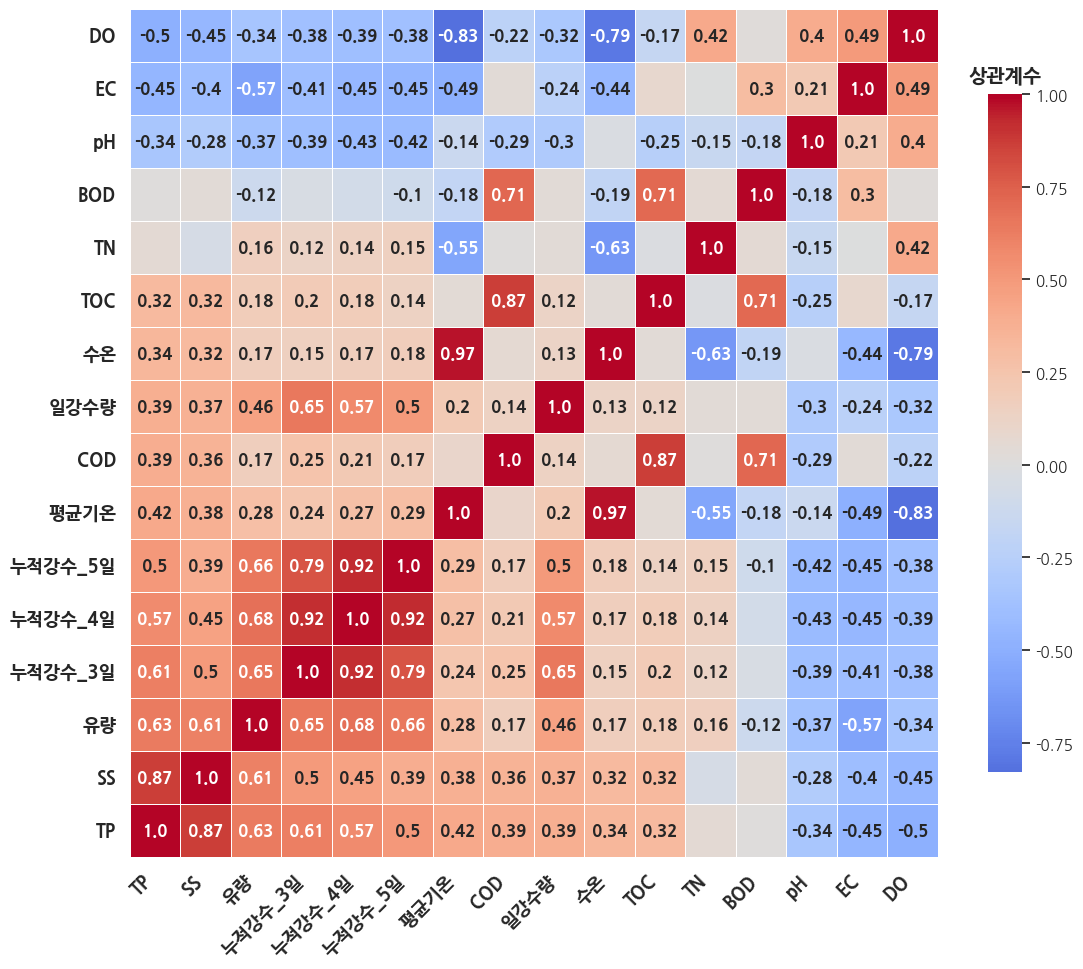

In [78]:
## 상관계수 히트맵

# ✅ seaborn 스타일 설정
sns.set_theme(style="whitegrid", font='NanumGothic', font_scale=1.0)

# ✅ 유의확률(p-value) 기준으로 annot 텍스트 마스킹
annot_matrix = corr_sorted.copy()

# p-value 행렬에서 현재 corr_sorted 순서에 맞게 정렬
pval_sorted = pval_matrix.loc[annot_matrix.index, annot_matrix.columns]

# p-value > 0.05인 경우 annot을 빈 문자열로 대체
annot_matrix = annot_matrix.round(2).astype(str)
annot_matrix[pval_sorted > 0.05] = ""

# 📊 히트맵 시각화
plt.figure(figsize=(11, 10))
ax = sns.heatmap(
    corr_sorted,
    annot=annot_matrix, fmt="",  # 유의하지 않은 값은 빈칸
    cmap="coolwarm", center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot_kws={"weight": "bold", "fontsize": 12}
)

# ✅ 컬러바 객체 가져오기 (가로 방향일 경우 마지막 axes)
cbar = ax.collections[0].colorbar

# ✅ 컬러바 제목 설정
cbar.ax.set_xlabel("상관계수", fontsize=14, weight='bold', labelpad=10)
cbar.ax.xaxis.set_label_position('top')  # 상단에 위치

# ✅ 축라벨 설정
plt.xticks(fontsize=13, weight='bold', rotation=45, ha='right')  # x축 라벨 45도 기울이기
plt.yticks(fontsize=13, weight='bold', rotation=0)  # y축 라벨은 수평 유지

# ✅ 그래프 여백 조정
plt.tight_layout(pad=1.5) # 상하좌우 여백 자동 조정  
plt.subplots_adjust(right=1.05)  # 우측 여백 조정

# 저장
plt.savefig("E:/Coding/TMDL/수질분석/Output/Plot/섬강A_상관계수.png", dpi=300)
plt.show()

In [29]:
# 🎨 계절별 색상 지정
season_palette = {
    '봄': '#F8766D',
    '여름': '#00BA38',
    '가을': '#619CFF',
    '겨울': '#C77CFF'
}

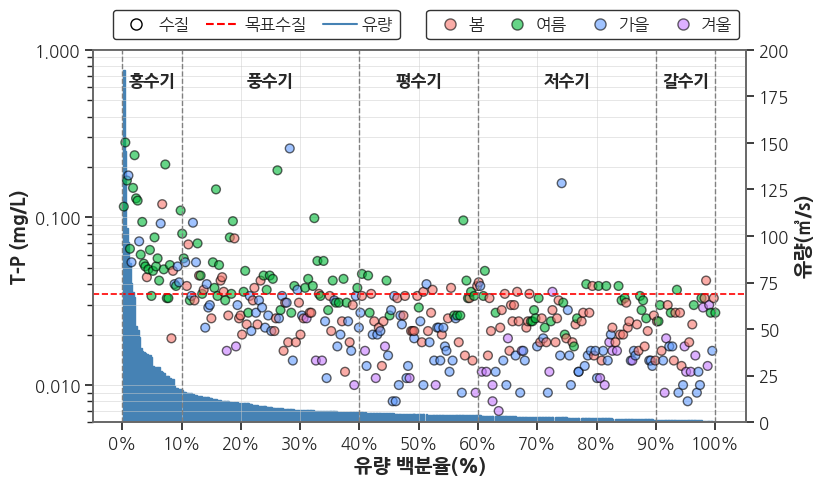

In [ ]:
## 유량 / 수질(T-P) 그래프

# 데이터 준비
데이터 = 총량측정망.copy()

# 계절별 색상 팔레트 적용
season_colors = 데이터['계절'].map(season_palette)

# 그래프 생성
fig, ax1 = plt.subplots(figsize=(8.4, 5))
ax2 = ax1.twinx()  # 보조 y축 생성

# 🔵 유량 막대
bars = ax2.bar(
    데이터['유량백분율'], 데이터['유량'],
    width=0.3, color='steelblue', edgecolor='steelblue', alpha=1,
    label='유량'
)
ax2.set_ylim(0, 200)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))  # y축 레이블 포맷팅(x를 정수로 변환하고, 천 단위 쉼표 추가)
ax2.grid(False)  # 보조 y축 격자선 제거

# ⚫ 수질 점
scatter = ax1.scatter(
    데이터['유량백분율'], 데이터['TP'],
    c=season_colors, edgecolor='black', s=40,
    alpha=0.6, label='수질'
)
ax1.set_yscale("log")
ax1.set_ylim(0.006, 1)
# y축 로그 스케일 유지하되 눈금은 일반 숫자로
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax1.ticklabel_format(axis='y', style='plain')
ax1.set_xticks(range(0, 101, 10))  # x축 눈금 설정
ax1.set_xticklabels([f"{x}%" for x in range(0, 101, 10)])  # x축 레이블 설정
ax1.grid(which='both', linestyle='-', linewidth=0.5, alpha=0.7)  # 격자선 설정

# 🔴 목표수질 선
ax1.axhline(y=목표수질_TP, color='red', linestyle='dashed', linewidth=1.2, label='목표수질')

# 🔲 수직선 (유황구간 기준선)
for x in [0, 10, 40, 60, 90, 100]:
    ax1.axvline(x=x, linestyle='dashed', linewidth=1, color='gray')

# 📝 유황구간 라벨
유황라벨 = {
    5: '홍수기', 25: '풍수기', 50: '평수기',
    75: '저수기', 95: '갈수기'
}
for x, label in 유황라벨.items():
    ax1.text(x, 0.65, label, ha='center', va='center', fontsize=12, weight='bold')

# 📌 축 레이블 제목 설정
ax1.set_xlabel("유량 백분율(%)", fontsize=14, weight='bold')
ax1.set_ylabel("T-P (mg/L)", fontsize=14, weight='bold')
ax2.set_ylabel("유량(㎥/s)", fontsize=14, weight='bold')

# 축 눈금 설정
ax1.tick_params(axis='both', labelsize=12)  # x축 + 왼쪽 y축
ax2.tick_params(axis='y', labelsize=12)     # 오른쪽 y축
# x축 눈금 바깥쪽으로
ax1.xaxis.set_ticks_position('bottom')

# ax2의 zorder를 얻고, ax2의 zorder보다 큰 값을 ax1의 zorder로 지정
# zorder가 낮을수록 먼저 그려지고, zorder가 높을수록 나중에 그려짐
ax1.set_zorder(ax2.get_zorder() + 10)
# ax1의 배경을 투명하게 만들어 ax1이 앞으로 배치되었을 때 ax2의 내용이 가려지지 않게 함
ax1.patch.set_visible(False)

# 축 테두리선 색상 변경
for spine in ax1.spines.values():
    spine.set_color('dimgray')
for spine in ax2.spines.values():
    spine.set_color('dimgray')

# 📌 범례 구성(수질/목표수질/유량 + 계절)
legend_handles = [
    plt.Line2D([0], [0], marker='o', linestyle='None',
               color='black', markerfacecolor='white', label='수질', markersize=8),
    plt.Line2D([0], [0], linestyle='--', color='red', label='목표수질'),
    plt.Line2D([0], [0], linestyle='-', color='steelblue', label='유량')
] + [
    plt.Line2D([0], [0], marker='o', linestyle='None', color='black', 
               markerfacecolor=color, alpha=0.6, label=label, markersize=8)
    for label, color in season_palette.items()
]

# 1️⃣ 수질 / 목표수질 / 유량 범례
legend1 = ax1.legend(
    handles=legend_handles[:3],  # 세번째 까지(0~2): 수질, 목표수질, 유량
    loc='upper center',
    ncol=3,
    frameon=True,  # 범례 테두리 표시
    edgecolor='black',  # 범례 테두리 색상
    bbox_to_anchor=(0.25, 1.13),
    fontsize=12,
    handletextpad=0.3,  # 범례 마커와 텍스트 간 간격
    columnspacing=1   # 범례 항목(열) 간 간격
)

# 2️⃣ 계절 범례
legend2 = ax1.legend(
    handles=legend_handles[3:],  # 네번째 부터: 계절(봄~겨울)
    loc='upper center',
    ncol=4,
    frameon=True,  # 범례 테두리 표시
    edgecolor='black',  # 범례 테두리 색상
    bbox_to_anchor=(0.75, 1.13),
    fontsize=12,
    title_fontsize=12,
    handletextpad=0.1,  # 범례 마커와 텍스트 간 간격
    columnspacing=1   # 범례 항목(열) 간 간격
)

# 첫 번째 범례를 그래프에 추가로 다시 등록
ax1.add_artist(legend1)

# 여백 조정
plt.subplots_adjust(top=0.82)
plt.tight_layout()
plt.show()


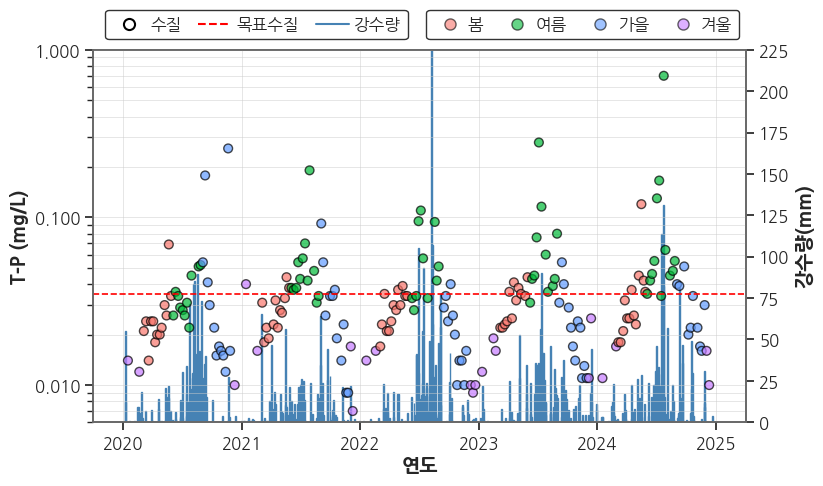

In [ ]:
## 강수 / 수질(T-P) 그래프

# 데이터 준비
데이터 = 총량측정망_기상.copy()
데이터['일자'] = pd.to_datetime(데이터['일자'])
데이터 = 데이터[데이터['연도'] >= 2020]

# 계절별 색상 팔레트 적용
season_colors = 데이터['계절'].map(season_palette)

# 그래프 생성
fig, ax1 = plt.subplots(figsize=(8.4, 5))
ax2 = ax1.twinx()  # 보조 y축 생성

# 🔵 강수량 막대 그래프
ax2.bar(
    데이터['일자'], 데이터['일강수량'],
    width=3, color='steelblue', edgecolor='steelblue', alpha=1.0, label='강수량'
)
ax2.set_ylim(0, 225)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))  # y축 레이블 포맷팅(x를 정수로 변환하고, 천 단위 쉼표 추가)
ax2.grid(False)  # 보조 y축 격자선 제거

# ⚫ 수질 점
scatter = ax1.scatter(
    데이터['일자'], 데이터['TP'],
    c=season_colors, edgecolor='black', s=40,
    label='수질(TP)', alpha=0.7
)
ax1.set_yscale("log")
ax1.set_ylim(0.006, 1)
# y축 로그 스케일 유지하되 눈금은 일반 숫자로
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax1.ticklabel_format(axis='y', style='plain')
ax1.xaxis.set_major_locator(mdates.YearLocator())  # 연도 단위로 x축 눈금 설정
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # 연도 형식으로 표시
ax1.grid(which='both', linestyle='-', linewidth=0.5, alpha=0.7)  # 격자선 설정

# 🔴 목표수질 선
ax1.axhline(y=목표수질_TP, color='red', linestyle='dashed', linewidth=1.2, label='목표수질')

# 📌 축 레이블 제목 설정
ax1.set_xlabel("연도", fontsize=14, weight='bold')
ax1.set_ylabel("T-P (mg/L)", fontsize=14, weight='bold')
ax2.set_ylabel("강수량(mm)", fontsize=14, weight='bold')

# 축 눈금 설정
ax1.tick_params(axis='both', labelsize=12)  # x축 + 왼쪽 y축
ax2.tick_params(axis='y', labelsize=12)     # 오른쪽 y축
# x축 눈금 바깥쪽으로
ax1.xaxis.set_ticks_position('bottom')

# ax2의 zorder를 얻고, ax2의 zorder보다 큰 값을 ax1의 zorder로 지정
# zorder가 낮을수록 먼저 그려지고, zorder가 높을수록 나중에 그려짐
ax1.set_zorder(ax2.get_zorder() + 10)
# ax1의 배경을 투명하게 만들어 ax1이 앞으로 배치되었을 때 ax2의 내용이 가려지지 않게 함
ax1.patch.set_visible(False)

# 축 테두리선 색상 변경
for spine in ax1.spines.values():
    spine.set_color('dimgray')
for spine in ax2.spines.values():
    spine.set_color('dimgray')

# 📌 범례 구성(수질/목표수질/강수량 + 계절)
legend_handles = [
    plt.Line2D([0], [0], marker='o', linestyle='None', 
               color='black', markerfacecolor='white', 
               label='수질', markersize=8, markeredgewidth=1.5),
    plt.Line2D([0], [0], linestyle='--', color='red', label='목표수질'),
    plt.Line2D([0], [0], linestyle='-', color='steelblue', label='강수량')
] + [
    plt.Line2D([0], [0], marker='o', linestyle='None', color='black', 
               markerfacecolor=color, alpha=0.6, label=label, markersize=8)
    for label, color in season_palette.items()
]

# 1️⃣ 수질 / 목표수질 / 강수량 범례
legend1 = ax1.legend(
    handles=legend_handles[:3],  # 세번째 까지(0~2): 수질, 목표수질, 강수량
    loc='upper center',
    ncol=3,
    frameon=True,  # 범례 테두리 표시
    edgecolor='black',  # 범례 테두리 색상
    bbox_to_anchor=(0.25, 1.13),
    fontsize=12,
    handletextpad=0.3,  # 범례 마커와 텍스트 간 간격
    columnspacing=1   # 범례 항목(열) 간 간격
)

# 2️⃣ 계절 범례
legend2 = ax1.legend(
    handles=legend_handles[3:],  # 네번째 부터: 계절(봄~겨울)
    loc='upper center',
    ncol=4,
    frameon=True,  # 범례 테두리 표시
    edgecolor='black',  # 범례 테두리 색상
    bbox_to_anchor=(0.75, 1.13),
    fontsize=12,
    title_fontsize=12,
    handletextpad=0.1,  # 범례 마커와 텍스트 간 간격
    columnspacing=1   # 범례 항목(열) 간 간격
)

# 첫 번째 범례를 그래프에 추가로 다시 등록
ax1.add_artist(legend1)

# 상단 여백 확보
plt.subplots_adjust(top=0.82)
plt.tight_layout()
plt.show()


C:\Users\TG\AppData\Local\Temp\ipykernel_30312\3675251777.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


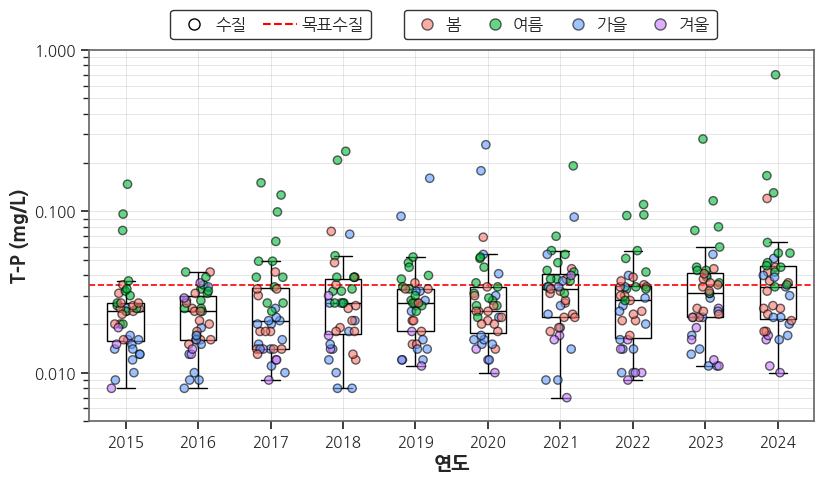

In [ ]:
## 연도 별 박스플롯

# 데이터 준비
데이터 = 총량측정망.copy()
데이터 = 데이터[데이터['TP'] > 0]  # 로그 스케일이므로 0 이상만 사용

# 계절별 색상 팔레트 적용
season_colors = 데이터['계절'].map(season_palette)

# 그래프 생성
fig, ax = plt.subplots(figsize=(8.4, 5))

# 📦 박스플롯 (이상치 표시 없이)
sns.boxplot(
    data=데이터, x='연도', y='TP',
    ax=ax, showfliers=False, width=0.5,
    color='white', linewidth=1,
    linecolor='black'
)

# ⚫ Jittered scatter
sns.stripplot(
    data=데이터, x='연도', y='TP',
    ax=ax, 
    jitter=0.2,  # 점들이 겹치지 않도록 약간의 무작위 이동
    size=6,
    edgecolor='black',
    linewidth=1,
    palette=season_palette,
    hue='계절',
    dodge=False,  # 계절별로 점을 분리하지 않음
    alpha=0.6, marker='o'
)

# 🔴 목표수질 수평선
ax.axhline(y=목표수질_TP, color='red', linestyle='--', linewidth=1.2, label='목표수질')

# 🧪 y축 로그 스케일
ax.set_yscale("log")
ax.set_ylim(0.005, 1)
# y축 로그 스케일 유지하되 눈금은 일반 숫자로
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(axis='y', style='plain')
ax.set_ylabel("T-P (mg/L)", fontsize=14, weight='bold')
ax.set_xlabel("연도", fontsize=14, weight='bold')
ax.grid(which='both', linestyle='-', linewidth=0.5, alpha=0.7)  # 격자선 설정

# 축 눈금 설정
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# 축 테두리선 색상 변경
for spine in ax.spines.values():
    spine.set_color('dimgray')

# 📌 범례 구성(수질/목표수질 + 계절)
legend_handles = [
    plt.Line2D([0], [0], marker='o', linestyle='None', color='black', 
               markerfacecolor='white', label='수질', markersize=8),
    plt.Line2D([0], [0], linestyle='--', color='red', label='목표수질')
] + [
    plt.Line2D([0], [0], marker='o', linestyle='None', color='black', 
               markerfacecolor=color, alpha=0.6, label=label, markersize=8)
    for label, color in season_palette.items()
]

# 1️⃣ 수질 / 목표수질 범례
legend1 = ax.legend(
    handles=legend_handles[:2],  # 두번째 까지(0~1): 수질, 목표수질
    loc='upper center',
    ncol=2,
    frameon=True,  # 범례 테두리 표시
    edgecolor='black',  # 범례 테두리 색상
    bbox_to_anchor=(0.25, 1.13),  # 범례 위치 조정
    fontsize=12,
    handletextpad=0.3,  # 범례 마커와 텍스트 간 간격
    columnspacing=1   # 범례 항목(열) 간 간격
)

# 2️⃣ 계절 범례
legend2 = ax.legend(
    handles=legend_handles[2:],  # 세번째 부터: 계절(봄~겨울)
    loc='upper center',  # 범례 위치
    ncol=4,  # 범례 항목 수
    frameon=True,  # 범례 테두리 표시
    edgecolor='black',  # 범례 테두리 색상
    bbox_to_anchor=(0.65, 1.13),  # 범례 위치 조정
    fontsize=12,
    title_fontsize=12,
    handletextpad=0.1,  # 범례 마커와 텍스트 간 간격
    columnspacing=1   # 범례 항목(열) 간 간격
)

# 첫 번째 범례를 그래프에 추가로 다시 등록
ax.add_artist(legend1)

# 🎨 기타 스타일
ax.tick_params(labelsize=11)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title("")  # 제목 없음

plt.subplots_adjust(top=0.85)
plt.tight_layout()
plt.show()

In [1]:
## 유량 / 수질(T-P) 그래프

# 데이터 준비
데이터 = 총량측정망.copy()

# 그래프 생성
fig, ax = plt.subplots(figsize=(8.4, 5))

# ⚫ 수질 점
scatter = ax.scatter(
    데이터['누적강수_3일'], 데이터['TP'],
    c='white', edgecolor='black', s=40,
    alpha=0.6, label='수질'
)
ax.set_yscale("log")
ax.set_ylim(0.006, 1)
# y축 로그 스케일 유지하되 눈금은 일반 숫자로
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(axis='y', style='plain')
ax.grid(which='both', linestyle='-', linewidth=0.5, alpha=0.7)  # 격자선 설정

# 🔴 목표수질 선
ax.axhline(y=목표수질_TP, color='red', linestyle='dashed', linewidth=1.2, label='목표수질')

# 📌 축 레이블 제목 설정
ax.set_xlabel("누적강수 3일(mm)", fontsize=14, weight='bold')
ax.set_ylabel("T-P (mg/L)", fontsize=14, weight='bold')

# 축 눈금 설정
ax.tick_params(axis='both', labelsize=12)  # x축 + 왼쪽 y축
# x축 눈금 바깥쪽으로
ax.xaxis.set_ticks_position('bottom')

# 축 테두리선 색상 변경
for spine in ax.spines.values():
    spine.set_color('dimgray')

# 📌 범례 구성(수질/목표수질)
legend_handles = [
    plt.Line2D([0], [0], marker='o', linestyle='None', color='black', 
               markerfacecolor='white', label='수질', markersize=8),
    plt.Line2D([0], [0], linestyle='--', color='red', label='목표수질')
]

# 1️⃣ 수질 / 목표수질 범례
legend = ax.legend(
    handles=legend_handles, 
    loc='upper center',  # 범례 위치
    ncol=2,  # 범례 항목 수
    frameon=True,  # 범례 테두리 표시
    edgecolor='black',  # 범례 테두리 색상
    bbox_to_anchor=(0.2, 1),  # 범례 위치 조정
    fontsize=12,
    handletextpad=0.3,  # 범례 마커와 텍스트 간 간격
    columnspacing=1   # 범례 항목(열) 간 간격
)

# 여백 조정
plt.subplots_adjust(top=0.82)
plt.tight_layout()
plt.show()

NameError: name '총량측정망' is not defined

In [ ]:
## 강우 이벤트별 수질 영향 분석

# 강우영향 샘플 구분(직전 3일 누적강수량이 20mm 이상이면 '강우영향')
#총량측정망['강우영향'] = 총량측정망['누적강수_3일'] >= 20
#총량측정망['강우영향_구분'] = 총량측정망['강우영향'].map({True: '강우영향', False: '평상시'})

# 라이브러리 로드
from scipy.stats import mannwhitneyu

# 스타일 설정
sns.set_theme(style="whitegrid", font="NanumGothic", font_scale=1.1)  # Windows 사용자 기준

# ===== 박스플롯: 최근 3일 고강도 강우 발생 여부 vs TP (목표수질 + 범례 포함) =====
# 로그 스케일 대응: TP>0, 결측 제거
plot_df = (
    총량측정망
    .dropna(subset=['TP', '고강도강우_발생여부_3일누적'])
    .query('TP > 0')
    .copy()
)

# x축 레이블을 보기 쉽게 한글 라벨로 변환
plot_df['최근3일_고강도발생'] = np.where(plot_df['고강도강우_발생여부_3일누적'], '발생', '무')

fig, ax = plt.subplots(figsize=(8.4, 5))

# 박스플롯
# - 색상은 pastel 팔레트 2색 사용(무/발생 순)
order = ['무', '발생']
palette = sns.color_palette('pastel', n_colors=2)

sns.boxplot(
    data=plot_df,
    x='최근3일_고강도발생', y='TP',
    order=order,
    palette=palette,
    showfliers=True,
    width=0.6,
    ax=ax
)

# 🔴 목표수질 수평선
ax.axhline(y=목표수질_TP, color='red', linestyle='--', linewidth=1.2, label='목표수질')

# 축/눈금/격자 스타일
ax.set_yscale("log")
ax.set_ylim(0.005, 1)  # 필요 시 조정
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(axis='y', style='plain')
ax.grid(which='both', linestyle='-', linewidth=0.5, alpha=0.7)

ax.set_ylabel("총인 (TP, mg/L)", fontsize=13, weight='bold')
ax.set_xlabel("최근 3일 고강도 강우 발생 여부", fontsize=13, weight='bold')

# 축 테두리선 색상
for spine in ax.spines.values():
    spine.set_color('dimgray')

# 축 눈금 위치
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# 🎯 범례 구성: '무', '발생' + '목표수질'
from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor=palette[0], edgecolor='black', label='무'),
    Patch(facecolor=palette[1], edgecolor='black', label='발생'),
    plt.Line2D([0], [0], linestyle='--', color='red', label='목표수질')
]

legend = ax.legend(
    handles=legend_handles,
    loc='upper center',
    ncol=3,
    frameon=True,
    edgecolor='black',
    bbox_to_anchor=(0.5, 1.12),
    fontsize=11,
    handletextpad=0.5,
    columnspacing=1.2
)

plt.subplots_adjust(top=0.86)
plt.tight_layout()
plt.show()

# %%
# 📊 통계검정: Mann-Whitney U 검정 (비모수)
tp_rain = 총량측정망[총량측정망['고강도강우_발생여부_3일누적'] == True]['TP'].dropna()
tp_dry = 총량측정망[총량측정망['고강도강우_발생여부_3일누적'] == False]['TP'].dropna()

stat, p_value = mannwhitneyu(tp_rain, tp_dry, alternative='two-sided')

print(f"📌 Mann-Whitney U 검정 결과:\n - 통계량: {stat:.2f}\n - p-value: {p_value:.3e}")
if p_value < 0.05:
    print("➡ 두 그룹 간 TP 농도 차이는 통계적으로 유의합니다.")
else:
    print("➡ 두 그룹 간 TP 농도 차이는 유의하지 않습니다.")